# Here we will explore the 4km downscaled CMIP6 data

In [116]:
from pathlib import Path
import numpy as np
import xarray as xr
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from xclim import units, sdba, indices
from xclim.core.calendar import percentile_doy

from distributed import Client
from dask_jobqueue import SLURMCluster


# tmp dir for writing downscaled data
tmp_adj_cmip6_fn = "{var_id}_{model}_{scenario}_adjusted.zarr"
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/explore_downscaled")

working_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling")
era5_dir = working_dir.joinpath("era5_zarr")
cmip6_dir = working_dir.joinpath("cmip6_zarr")
downscaled_dir = working_dir.joinpath("adjusted")

cmip6_das = {}
# lookups

era5_var_id_lu = {"t2max": "tasmax", "pr": "pr"}
units_lu = {"pr": "mm d-1", "tasmax": "degC", "dtr": "degC"}
hist_ref_indices = ["wsdi", "tx90p"]

all_models = [
    "MIROC6",
    "GFDL-ESM4",
    "CNRM-CM6-1-HR",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "KACE-1-0-G",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorESM2-MM",
    "TaiESM1",
    "CESM2",
    "EC-Earth3-Veg",
]
for model in all_models:
    cmip6_das[model] = {}
    for scenario in ["historical", "ssp585"]:
        cmip6_das[model][scenario] = {}

In [ ]:
def open_era5_dataset(era5_stores):
    """Open the ERA5 dataset from the given zarr stores."""
    # open and convert calendar to noleap
    era5_ds = xr.merge(
        [xr.open_zarr(store) for store in era5_stores.values()]
    ).convert_calendar("noleap")

    era5_ds = era5_ds.assign_coords(time=era5_ds.time.dt.floor("D"))

    # set the correct compatible precipitation units for ERA5 if precip
    for era5_var_id in era5_stores.keys():
        var_id = era5_var_id_lu[era5_var_id]
        # first rename the variable to the shared CMIP6 name
        era5_ds = era5_ds.rename({era5_var_id: var_id})
        # Make units proper if needed
        if era5_ds[var_id].attrs["units"] == "mm":
            era5_ds[var_id].attrs["units"] = "mm d-1"
        # convert to shared units
        era5_ds[var_id] = units.convert_units_to(era5_ds[var_id], units_lu[var_id])

    return era5_ds

In [ ]:
# for interactive nb testing
cluster = SLURMCluster(
    cores=28,
    processes=14,
    # n_workers=14,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="4:00:00",
    log_directory="/beegfs/CMIP6/kmredilla/tmp/dask_jobqueue_logs",
    account="cmip6",
    interface="ib0",
)
client = Client(cluster)

In [ ]:
cluster.scale(n=140)

In [6]:
# connect to ERA5 data
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}
era5_ds = open_era5_dataset(era5_stores)
era5_ds.load()

<xarray.Dataset> Size: 30GB
Dimensions:      (time: 18250, y: 460, x: 443)
Coordinates:
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
  * time         (time) object 146kB 1965-01-01 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    spatial_ref  (time) float64 146kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tasmax       (time, y, x) float32 15GB nan nan nan nan ... nan nan nan nan
    pr           (time, y, x) float32 15GB nan nan nan nan ... nan nan nan nan

In [ ]:
rx1day = indices.max_1day_precipitation_amount(era5_ds["pr"])
dpi = indices.daily_pr_intensity(era5_ds["pr"])
rx1day.name = "rx1day"
dpi.name = "dpi"

su_20 = indices.tx_days_above(era5_ds["tasmax"], thresh="20.0 degC")
dw_30 = indices.tx_days_below(era5_ds["tasmax"], thresh="-30.0 degC")
su_20.name = "su_20"
dw_30.name = "dw_30"

era5_idx_ds = xr.merge([rx1day, dpi, su_20, dw_30])

In [28]:
del era5_ds

In [9]:
# scenario = "historical"
# dss = []
# for model in all_models:
for model in ["EC-Earth3-Veg", "CESM2"]:
    for scenario in ["historical", "ssp585"]:
        fp = downscaled_dir.joinpath(
            tmp_adj_cmip6_fn.format(var_id="pr", model=model, scenario=scenario)
        )
        if not fp.exists():
            print("No data for model", model, "scenario", scenario, f"({fp})")
            continue
        ds = xr.open_dataset(fp)
        ds.load()
        # cmip6_das[model][scenario]["rx1day"] = indices.max_1day_precipitation_amount(ds["pr"])
        # cmip6_das[model][scenario]["dpi"] = indices.daily_pr_intensity(ds["pr"])
        rx1day = indices.max_1day_precipitation_amount(ds["pr"])
        dpi = indices.daily_pr_intensity(ds["pr"])
        rx1day.name = "rx1day"
        dpi.name = "dpi"

        fp = downscaled_dir.joinpath(
            tmp_adj_cmip6_fn.format(var_id="tasmax", model=model, scenario=scenario)
        )
        if not fp.exists():
            print("No data for model", model, "scenario", scenario, f"({fp})")
            continue
        ds = xr.open_dataset(fp)
        ds.load()
        # cmip6_das[model][scenario]["su_20"] = indices.tx_days_above(ds["tasmax"], thresh='20.0 degC')
        # cmip6_das[model][scenario]["dw_30"] = indices.tx_days_below(ds["tasmax"], thresh='-30.0 degC')
        su_20 = indices.tx_days_above(ds["tasmax"], thresh="20.0 degC")
        dw_30 = indices.tx_days_below(ds["tasmax"], thresh="-30.0 degC")
        su_20.name = "su_20"
        dw_30.name = "dw_30"

        idx_ds = xr.merge([rx1day, dpi, su_20, dw_30])
        idx_ds = idx_ds.assign_coords(model=model, scenario=scenario).expand_dims(
            ["model", "scenario"]
        )
        dss.append(idx_ds)
        print(model, "done")

No data for model EC-Earth3-Veg scenario historical (/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/pr_EC-Earth3-Veg_historical_adjusted.zarr)
No data for model EC-Earth3-Veg scenario ssp585 (/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/pr_EC-Earth3-Veg_ssp585_adjusted.zarr)
No data for model CESM2 scenario historical (/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/tasmax_CESM2_historical_adjusted.zarr)
No data for model CESM2 scenario ssp585 (/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/tasmax_CESM2_ssp585_adjusted.zarr)


In [ ]:
tmp_idx_fn = "{model}_{scenario}_indices.zarr"
models = []
for ds in dss:
    model = ds.model.values[0]
    models.append(str(model))
    scenario = ds.scenario.values[0]
    store_path = tmp_dir.joinpath(tmp_idx_fn.format(model=model, scenario=scenario))
    # ds.transpose("model", "scenario", "time", "y", "x").to_zarr(store_path)

In [ ]:
# load previously computed indices
tmp_idx_fn = "{model}_{scenario}_indices.zarr"
scenarios = ["historical", "ssp585"]
models = [
    "GFDL-ESM4",
    "HadGEM3-GC31-MM",
    "KACE-1-0-G",
    "MRI-ESM2-0",
    "CNRM-CM6-1-HR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "HadGEM3-GC31-LL",
    "NorESM2-MM",
]

store_paths = []
for model in models:
    for scenario in scenarios:
        store_path = tmp_dir.joinpath(tmp_idx_fn.format(model=model, scenario=scenario))
        store_paths.append(store_path)

idx_ds = xr.open_mfdataset(store_paths)

In [79]:
projected_coords = {
    "Fairbanks": {"x": 297504.537742375, "y": 1667301.4672914068},
    "Anchorage": {"x": 219385.09124775976, "y": 1255247.7055300924},
}

In [64]:
sel_dis = {
    "southcentral": {"x": slice(1e5, 6e5), "y": slice(1.5e6, 1e6)},
    "interior": {"x": slice(2e5, 7e5), "y": slice(2e6, 1.5e6)},
    "2040-2069": {"time": slice("2040-01-01", "2069-12-31")},
    "2070-2099": {"time": slice("2070-01-01", "2099-12-31")},
}

In [ ]:
def add_label(axs, label):
    for ax in axs.flatten():
        ax.scatter(
            projected_coords[label]["x"], projected_coords[label]["y"], color="black"
        )
        ax.text(
            projected_coords[label]["x"],
            projected_coords[label]["y"] - 5e4,
            label,
            color="black",
        )

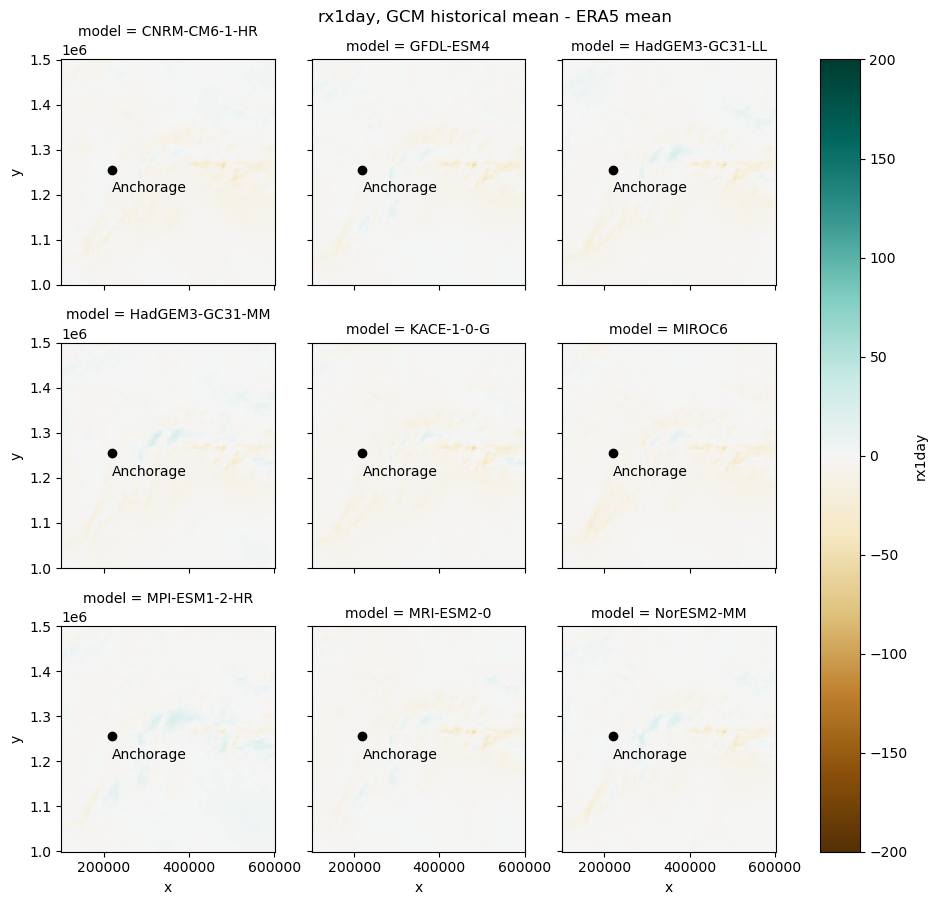

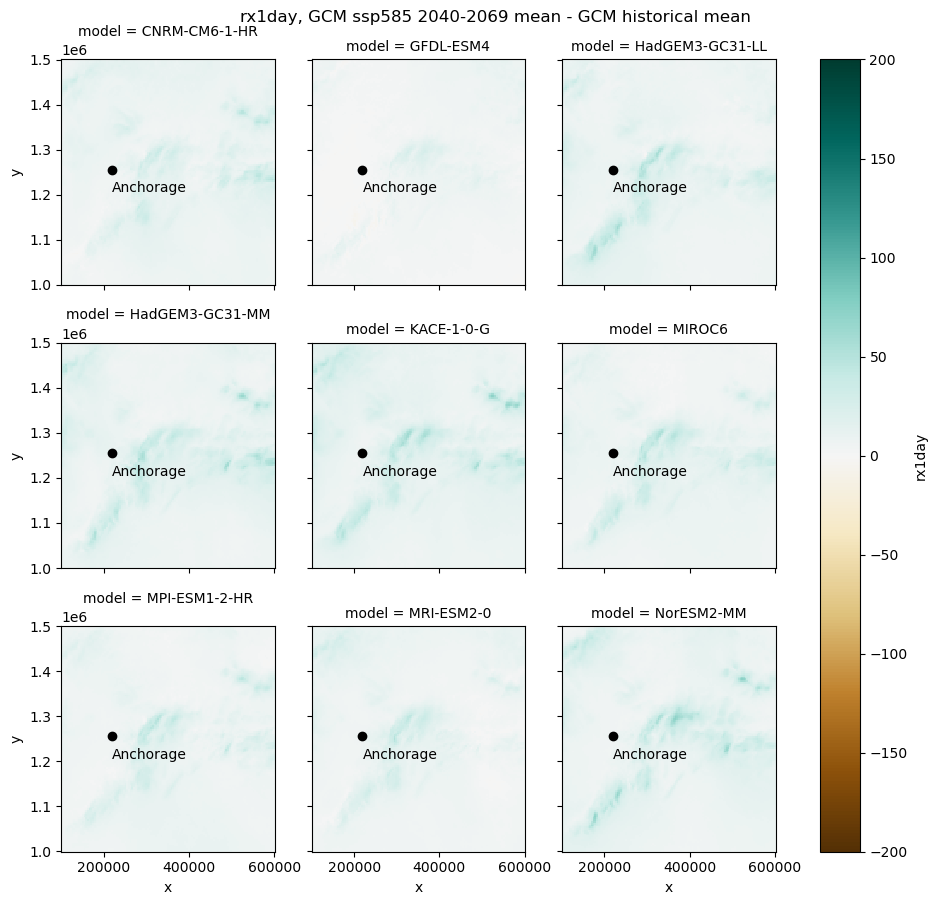

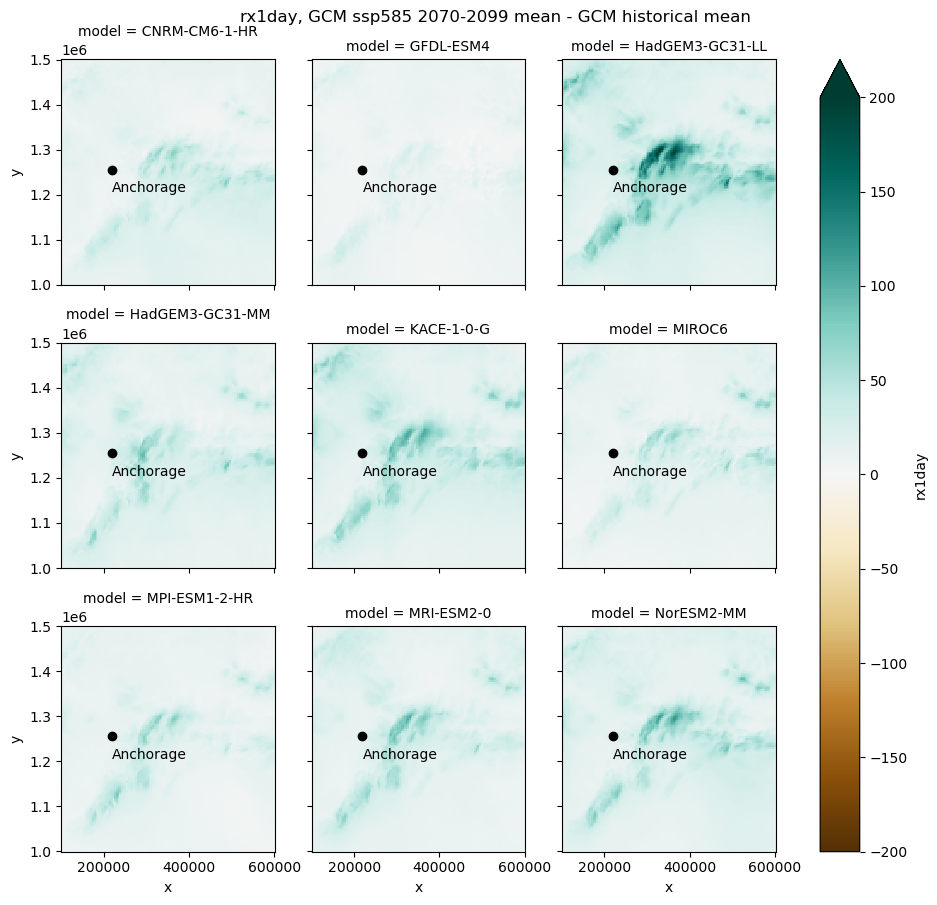

In [ ]:
location = "southcentral"
idx = "rx1day"
label = "Anchorage"
cmap = "BrBG"
vmin = -200
vmax = 200
g = (
    idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
    - era5_idx_ds[idx].sel(**sel_dis[location]).mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM historical mean - ERA5 mean", y=1)
plt.show()


clim = "2040-2069"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

clim = "2070-2099"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

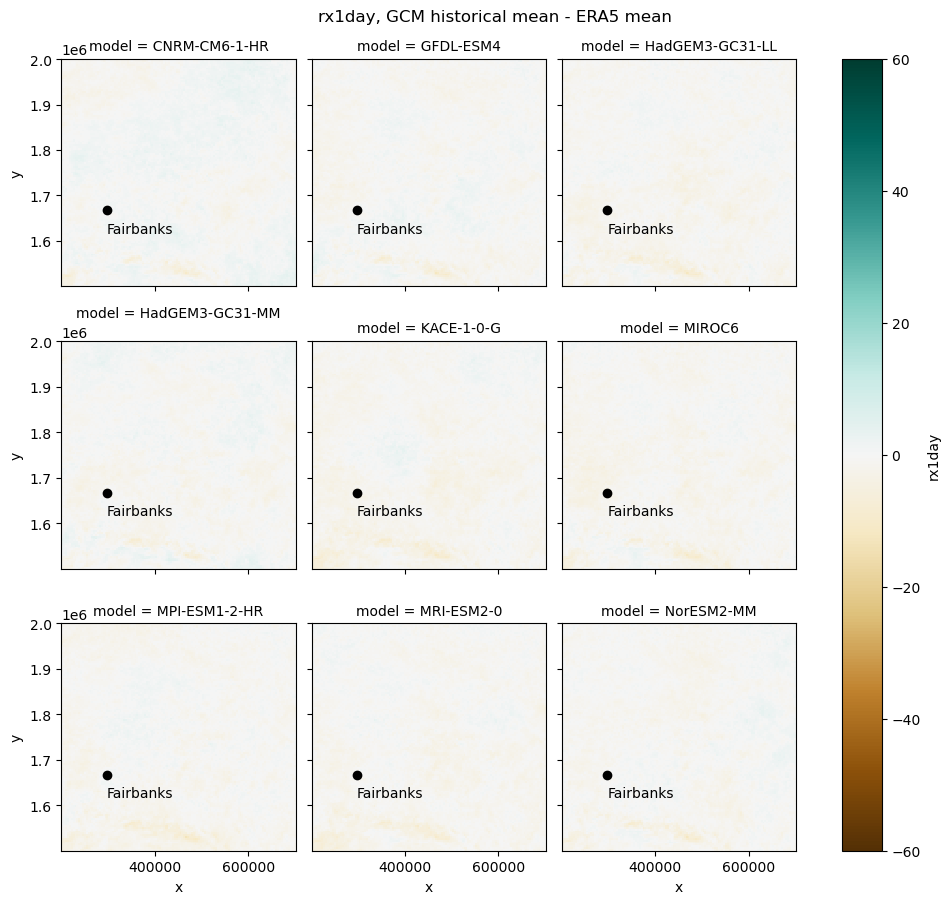

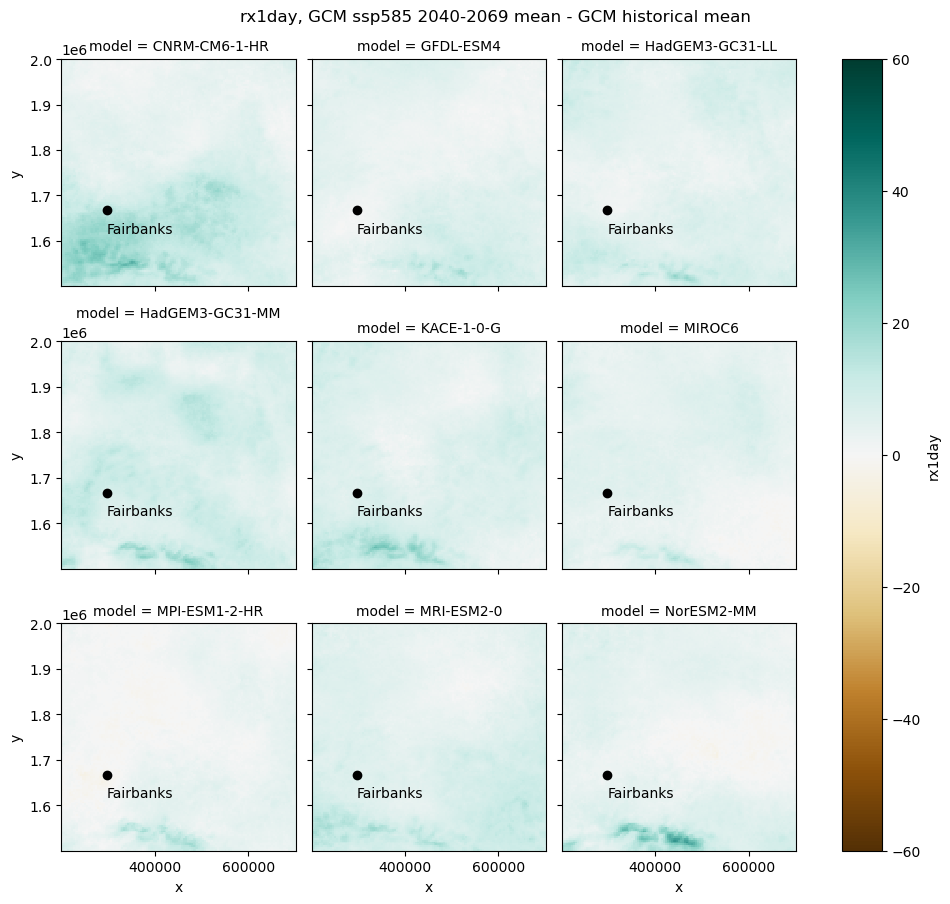

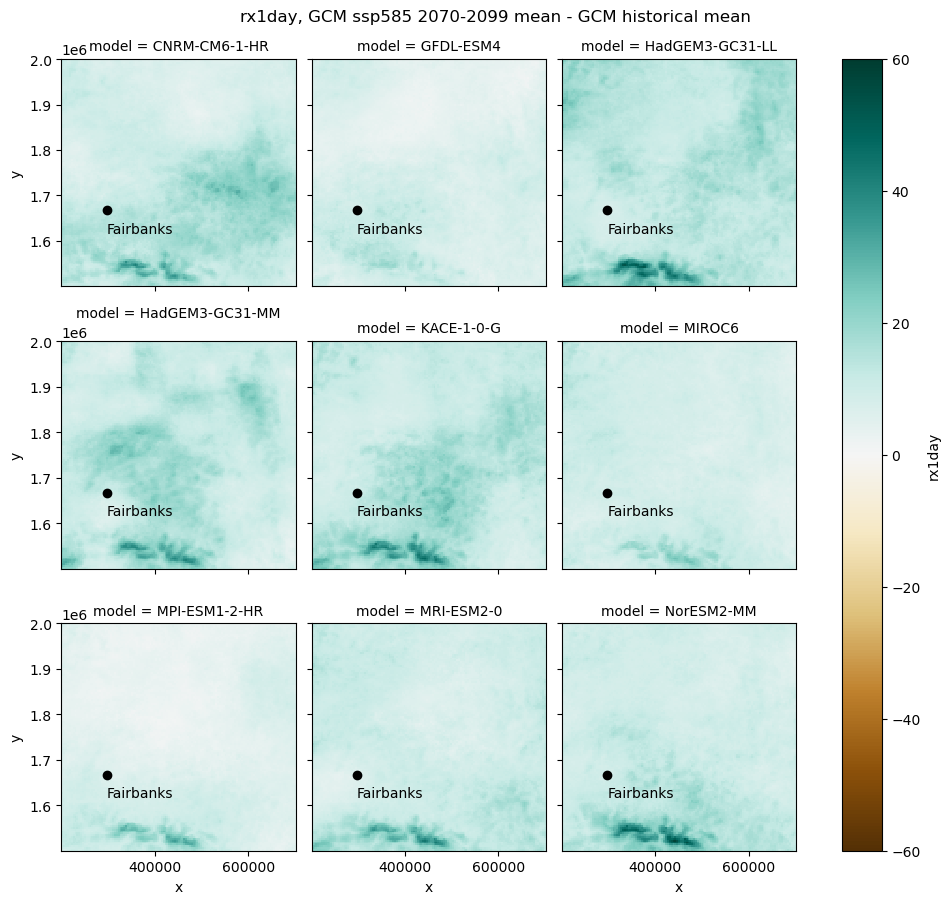

In [ ]:
location = "interior"
idx = "rx1day"
label = "Fairbanks"
cmap = "BrBG"
vmin = -60
vmax = 60
g = (
    idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
    - era5_idx_ds[idx].sel(**sel_dis[location]).mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM historical mean - ERA5 mean", y=1)
plt.show()


clim = "2040-2069"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

clim = "2070-2099"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

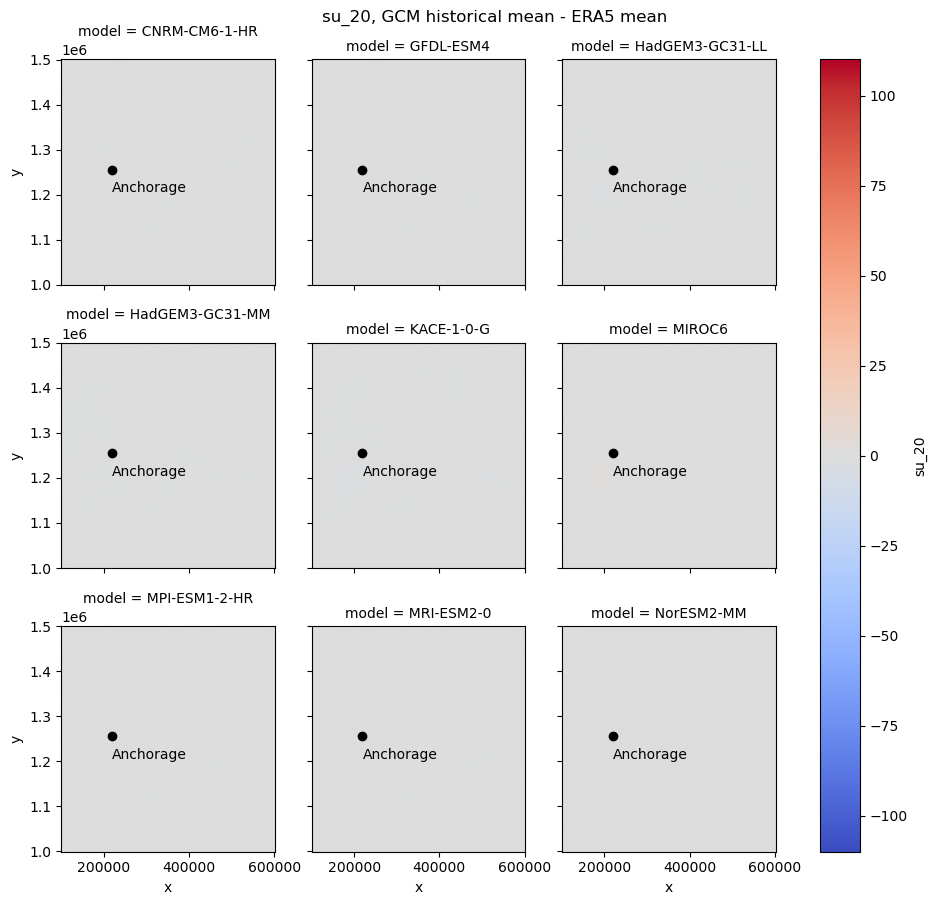

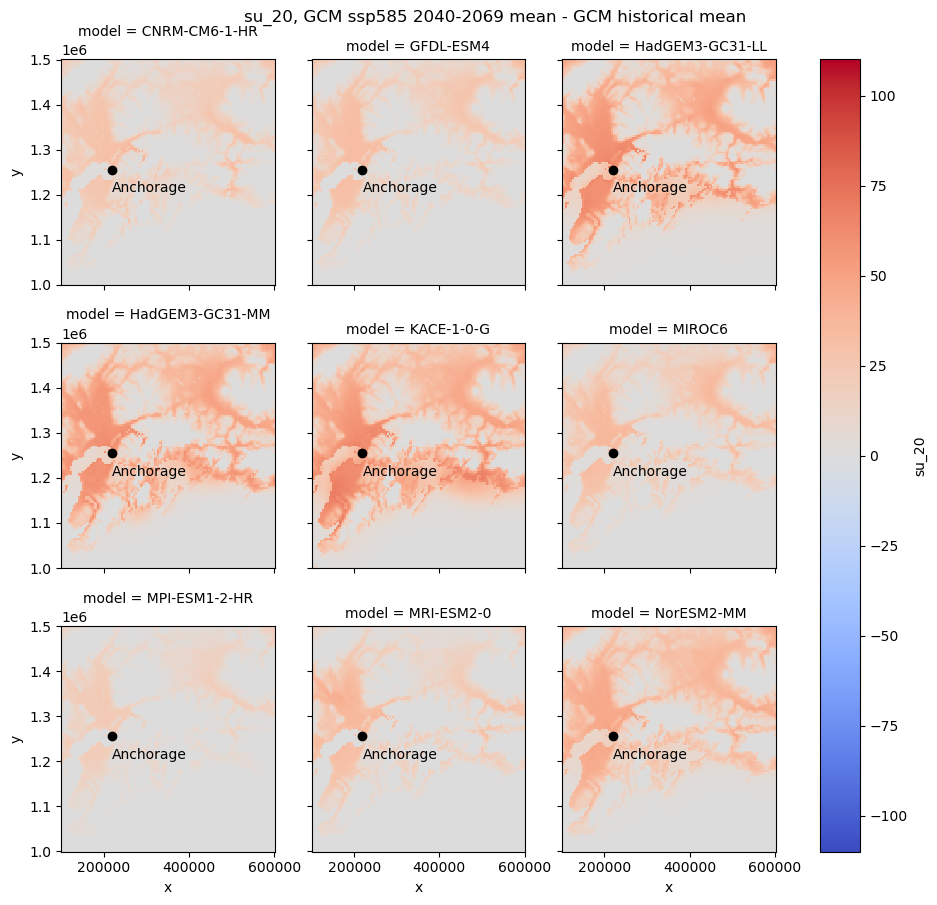

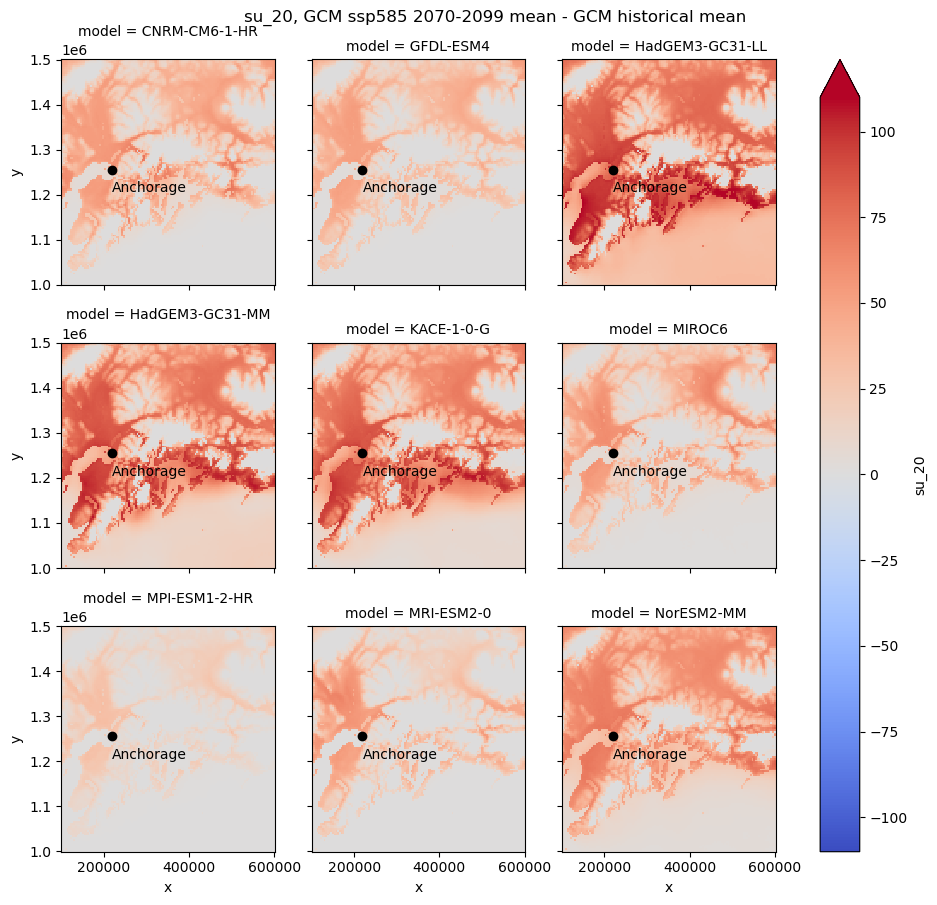

In [ ]:
location = "southcentral"
idx = "su_20"
label = "Anchorage"
cmap = "coolwarm"
vmin = -110
vmax = 110
g = (
    idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
    - era5_idx_ds[idx].sel(**sel_dis[location]).mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM historical mean - ERA5 mean", y=1)
plt.show()


clim = "2040-2069"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

clim = "2070-2099"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

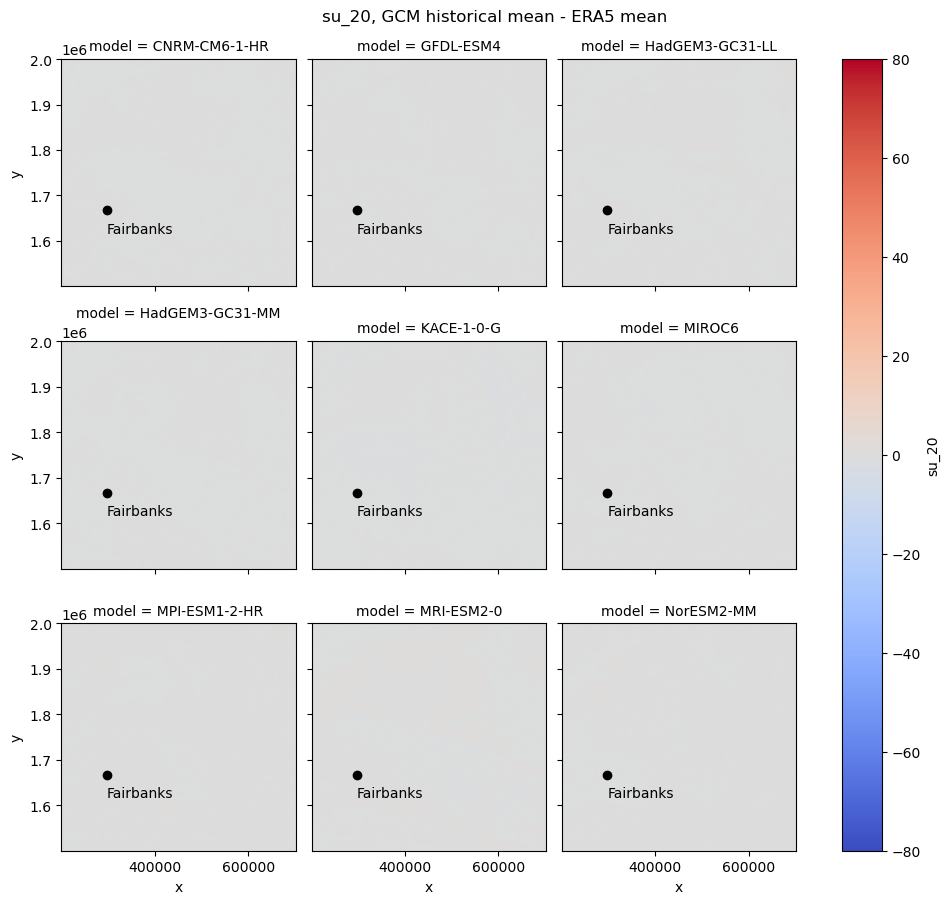

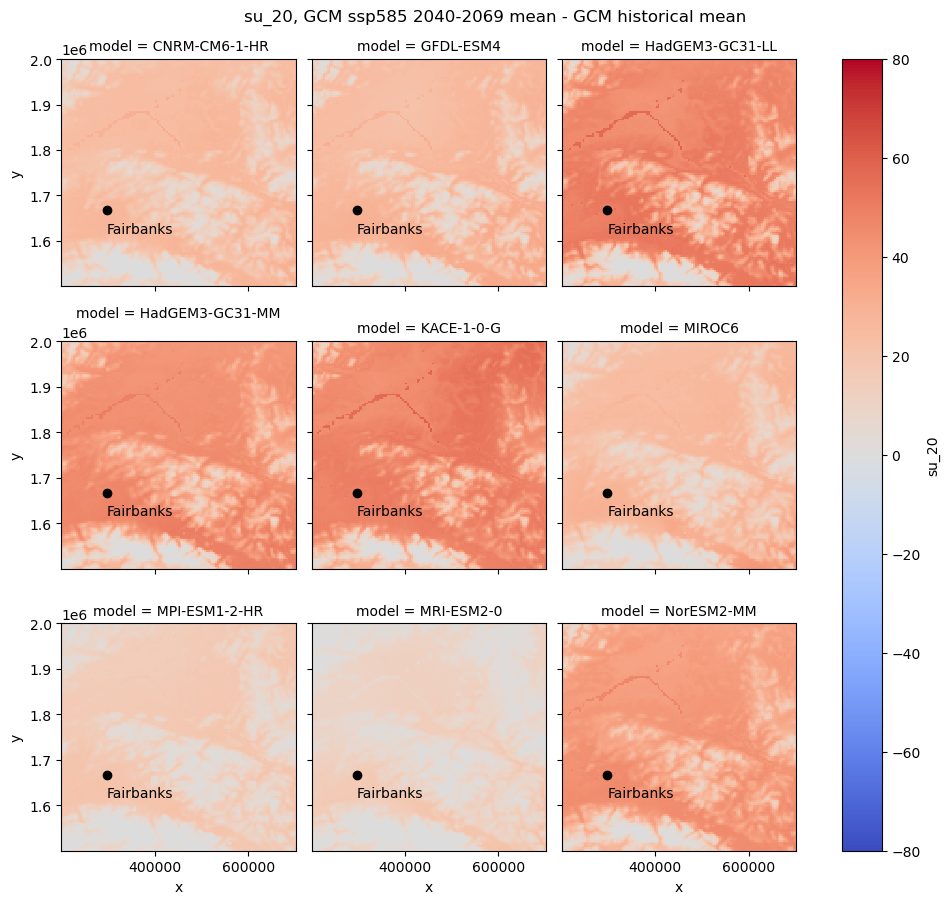

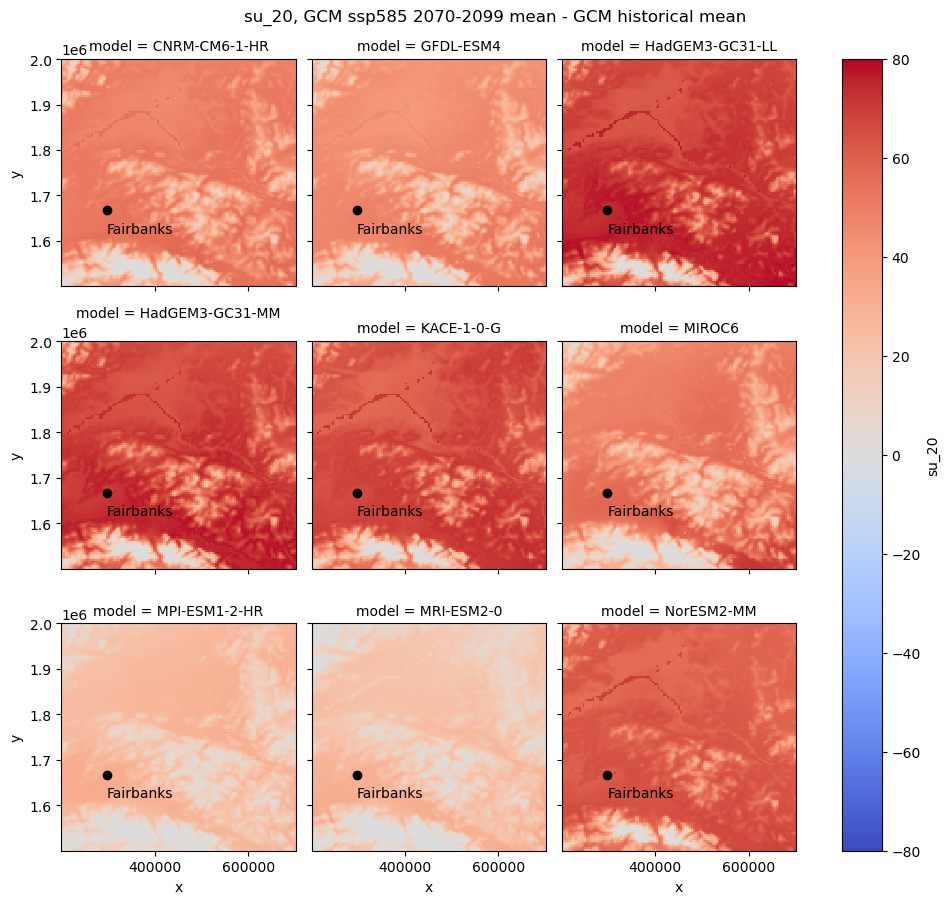

In [ ]:
location = "interior"
idx = "su_20"
label = "Fairbanks"
cmap = "coolwarm"
vmin = -80
vmax = 80
g = (
    idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
    - era5_idx_ds[idx].sel(**sel_dis[location]).mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM historical mean - ERA5 mean", y=1)
plt.show()


clim = "2040-2069"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

clim = "2070-2099"
g = (
    idx_ds[idx]
    .sel(**sel_dis[location])
    .sel(scenario="ssp585")
    .sel(**sel_dis[clim])
    .mean("time")
    - idx_ds[idx].sel(**sel_dis[location]).sel(scenario="historical").mean("time")
).plot(x="x", col="model", col_wrap=3, cmap=cmap, vmin=vmin, vmax=vmax)
add_label(g.axs, label)

plt.suptitle(f"{idx}, GCM ssp585 {clim} mean - GCM historical mean", y=1)
plt.show()

In [ ]:
das = []

for model in ["GFDL-ESM4", "MIROC6"]:
    for scenario in ["historical", "ssp585"]:
        for idx in ["rx1day", "dpi", "su_20", "dw_30"]:
            tmp_da = (
                cmip6_das[model][scenario][idx]
                .assign_coords(model=model, scenario=scenario)
                .expand_dims(["model", "scenario"])
            )
            tmp_da.name = idx
            das.append(tmp_da)

In [33]:
cmip6_idx_ds = xr.merge(das)

In [44]:
ds.load()

<xarray.Dataset> Size: 15GB
Dimensions:      (y: 460, x: 443, time: 18250)
Coordinates:
    lat          (y, x) float64 2MB 70.99 71.01 71.02 71.03 ... 54.8 54.8 54.79
    lon          (y, x) float64 2MB -176.7 -176.6 -176.5 ... -139.3 -139.2
    spatial_ref  int64 8B 0
  * time         (time) object 146kB 1965-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
Data variables:
    pr           (y, time, x) float32 15GB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:        CF-1.7
    activity_id:        CMIP
    contact:            uaf-snap-data-tools@alaska.edu
    creation_date:      2025-05-15T16:14:16
    experiment_id:      historical
    history:            File was processed by Scenarios Network for Alaska an...
    institution_id:     CNRM-CERFACS
    mip_era:            CMIP6
    parent_attributes:  {'CMIP6_CV_version': 'cv=6.2.3.0-7-g2019642', 'Conven...
    source_id:          CNRM-CM6-1-HR
    table_id:           day
    variable_id:        pr

In [45]:
cmip6_das[model][scenario]["rx1day"] = indices.max_1day_precipitation_amount(ds["pr"])

In [ ]:
rx1day

In [ ]:
del cmip6_das[model][scenario]["rx1day"]

In [18]:
model

'TaiESM1'